In [1]:
import pyfits as pf
import pickle 
import dill 
import numpy as np
import sys, os
os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/'
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/cosmosis_code/')
import twopoint
import pyfits as pf

sdir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/'
ldir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/'



# load template *****
fiducial = pf.open(sdir + 'v0.40_fiducial.fits')
# load n(z) ******
import numpy as np
from scipy.signal import savgol_filter
nzsamp = np.load('/global/cscratch1/sd/alexalar/desy3data/Nz_samples/v0.50/3sdir_fid_zsamplefid//nz_samples.npy')
nzsamp = savgol_filter(nzsamp,5,2,axis=2)
nz_tot=np.mean(nzsamp,axis=0)
z_samp = np.load('/global/cscratch1/sd/alexalar/desy3data/Nz_samples/sv_sn_test1///bin_centers.npy')
z_edge_samp = np.load('/global/cscratch1/sd/alexalar/desy3data/Nz_samples/sv_sn_test1///bin_edges.npy')





/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def covariance_jck(TOTAL_PHI,jk_r,type_cov):
  if type_cov=='jackknife':
      fact=(jk_r-1.)/(jk_r)
  elif type_cov=='bootstrap':
      fact=1./(jk_r)
  #  Covariance estimation
  average=np.zeros(TOTAL_PHI.shape[0])
  cov_jck=np.zeros((TOTAL_PHI.shape[0],TOTAL_PHI.shape[0]))
  err_jck=np.zeros(TOTAL_PHI.shape[0])
  for kk in range(jk_r):
    average+=TOTAL_PHI[:,kk]
  average=average/(jk_r)
 # print average
  for ii in range(TOTAL_PHI.shape[0]):
     for jj in range(ii+1):
          for kk in range(jk_r):
            cov_jck[jj,ii]+=TOTAL_PHI[ii,kk]*TOTAL_PHI[jj,kk]
          cov_jck[jj,ii]=(-average[ii]*average[jj]*jk_r+cov_jck[jj,ii])*fact
          cov_jck[ii,jj]=cov_jck[jj,ii]
  for ii in range(TOTAL_PHI.shape[0]):
   err_jck[ii]=np.sqrt(cov_jck[ii,ii])
 # print err_jck
  #compute correlation
  corr=np.zeros((TOTAL_PHI.shape[0],TOTAL_PHI.shape[0]))
  for i in range(TOTAL_PHI.shape[0]):
      for j in range(TOTAL_PHI.shape[0]):
        corr[i,j]=cov_jck[i,j]/(np.sqrt(cov_jck[i,i]*cov_jck[j,j]))
  average=average*fact
  return {'cov' : cov_jck,
          'err' : err_jck,
          'corr':corr,
          'mean':average}



In [34]:
# make n(z)
Nz = []
from scipy.interpolate import interp1d
for i in range(4):
    f = interp1d(z_samp,nz_tot[i])
    nz_e = np.zeros(len(fiducial[6].data['Z_MID']))
    mask = fiducial[6].data['Z_MID'] > z_samp[0]
    nz_e[mask] = f(fiducial[6].data['Z_MID'][mask])
    Nz.append(nz_e)
nz_full  = twopoint.NumberDensity("nz_source", fiducial[6].data['Z_LOW'], fiducial[6].data['Z_MID'], fiducial[6].data['Z_HIGH'], Nz)

Nz = []
from scipy.interpolate import interp1d
for i in range(5):
    Nz.append(fiducial[7].data['BIN{0}'.format(i+1)])
nz_LENS  = twopoint.NumberDensity("nz_lens", fiducial[7].data['Z_LOW'], fiducial[7].data['Z_MID'], fiducial[7].data['Z_HIGH'], Nz)





# this is to use the same theta as in the theory code - 
import math
theta1 = np.array([0.00083136, 0.00103403, 0.00130175, 0.0016388 , 0.0020631  ,0.00259727,
 0.00326974, 0.00411633, 0.00518211, 0.00652383, 0.00821295, 0.0103394,
 0.01301642, 0.01638656, 0.02062929, 0.02597051, 0.03269466, 0.04115979,
 0.05181666, 0.06483276])
theta = theta1*(60./((2*math.pi)/360))


import pickle
def load_obj(name):
    
        try:
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f)#, encoding='latin1')
        except:
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f, encoding='latin1')
            
            

import sys, os
sys.path.insert(0,  '/global/cscratch1/sd/mgatti/Mass_Mapping/TSZ_ACT/cosmosis//cosmosis-standard-library/likelihood/2pt')

from enum34 import Enum
class Types(Enum):
    """
    This is an enumeration - a list of possible values with names and code values
    that we can use in FITS headers.

    It enumerates the different quantities that a two-point measurement can correlate.
    For example, CMB T,E,B, lensing E and B, galaxy position and magnification.

    It specifies the quantity and whether we are in Fourier space or real space.

    One special case is xi_{-} and xi_{+} in galaxy shear.  These values are already
    correlations of combinations of E and B modes. We denote this as xi_{++} and xi_{--} here.

    """
    galaxy_position_fourier = "GPF"
    galaxy_shear_emode_fourier = "GEF"
    galaxy_shear_bmode_fourier = "GBF"
    galaxy_position_real = "GPR"
    galaxy_shear_plus_real = "G+R"
    galaxy_shear_minus_real = "G-R"
    cmb_kappa_real = "CKR"
    compton = 'compton'
    compton1 = 'compton1'

#     @classmethodsig
    def lookup(cls, value):
        for T in cls:
            if T.value == value:
                return T
            
  
                   
store_xipxim = dict()
store_tsz = dict()
count =0
for l in range(4):
    for s in range(4):
        try:
            store_xipxim["{0} {1}".format(l,s)] = dict()
            
            path_save = '/global/cscratch1/sd/mgatti/Cosmic_shear/output_tsz/rerun_mastercat_4_20/'
            mute = load_obj(path_save+'_shearshear_{0}_{1}__tsz__tsz'.format(l,s))
            store_xipxim["{0} {1}".format(l,s)]["xip"] = mute['high']['xip1']
            store_xipxim["{0} {1}".format(l,s)]["xim"] = mute['high']['xim1']
            
            if l>= s:
                if count == 0:
                    covp = mute["high"]["corr_jckp"].T
                    covm = mute["high"]["corr_jckm"].T

                else:
                    covp = np.vstack([covp,mute["high"]["corr_jckp"].T])
                    covm = np.vstack([covm,mute["high"]["corr_jckm"].T])

                count+=1
        except:
            pass
count =0
for l in range(4):
    store_tsz["{0}".format(l)] = dict()
    y3 = load_obj(path_save +'/_Yshear_{0}__tsz__tsz'.format(l))
    y3_ACT = load_obj(path_save +'/_YACT_shear_{0}__tsz_ACT__tsz'.format(l))
    
    store_tsz["{0}".format(l)]["tsz"] = y3['high']['xip1']
    store_tsz["{0}".format(l)]["tsz ACT"] = y3_ACT['high']['xip1']
    if count == 0:
        cov_tsz = y3["high"]["corr_jckp"].T
        cov_tsz_ACT = y3_ACT["high"]["corr_jckm"].T
    else:
        cov_tsz = np.vstack([cov_tsz,y3["high"]["corr_jckp"].T])
        cov_tsz_ACT = np.vstack([cov_tsz_ACT,y3_ACT["high"]["corr_jckm"].T])
    count+=1
cov_f = np.vstack([covp,covm,cov_tsz])
cov_f_ACT = np.vstack([covp,covm,cov_tsz_ACT])
cov_f_planck_ACT = np.vstack([covp,covm,cov_tsz,cov_tsz_ACT])

cov_dict = covariance_jck(cov_f,200,"jackknife")
cov_dict_ACT = covariance_jck(cov_f_ACT,200,"jackknife")
cov_dict_planck_ACT = covariance_jck(cov_f_planck_ACT,200,"jackknife")





angular_bins = 20
tsz_dv = np.zeros(20*4)
tsz_ACT_dv = np.zeros(20*4) 
tsz_bin1 = np.zeros(20*4) 
tsz_bin2 = np.zeros(20*4) 
tsz_angular_bin = np.zeros(20*4) 
tsz_angle = np.zeros(20*4) 
count = 0
for l in range(4):
    tsz_dv[count*angular_bins:(count+1)*angular_bins] = store_tsz["{0}".format(l)]["tsz"]
    tsz_ACT_dv[count*angular_bins:(count+1)*angular_bins] = store_tsz["{0}".format(l)]["tsz ACT"]
    tsz_bin1[count*angular_bins:(count+1)*angular_bins] = l+1
    tsz_bin2[count*angular_bins:(count+1)*angular_bins] = l+1
        
    tsz_angular_bin[count*angular_bins:(count+1)*angular_bins] = np.arange(len(theta))
    tsz_angle[count*angular_bins:(count+1)*angular_bins] = theta
    count +=1
            
            
            
            
angular_bins = 20
cosmic_shear_p = np.zeros(20*10)
cosmic_shear_m = np.zeros(20*10) 
bin1 = np.zeros(20*10) 
bin2 = np.zeros(20*10) 
angular_bin = np.zeros(20*10) 
angle = np.zeros(20*10) 
count = 0
for l in range(4):
    for s in range(4):
        if l>=s:
               cosmic_shear_p[count*angular_bins:(count+1)*angular_bins] = store_xipxim["{0} {1}".format(l,s)]["xip"]
               cosmic_shear_m[count*angular_bins:(count+1)*angular_bins] = store_xipxim["{0} {1}".format(l,s)]["xim"]
       

               bin1[count*angular_bins:(count+1)*angular_bins] = l+1
               bin2[count*angular_bins:(count+1)*angular_bins] = s+1
        
               angular_bin[count*angular_bins:(count+1)*angular_bins] = np.arange(len(theta))
               angle[count*angular_bins:(count+1)*angular_bins] = theta
               count +=1

            
shearp = twopoint.SpectrumMeasurement('xip', (bin1, bin2),
                                                     (twopoint.Types.galaxy_shear_plus_real,
                                                      twopoint.Types.galaxy_shear_plus_real),
                                                     ['no_nz', 'no_nz'], 'SAMPLE', angular_bin, cosmic_shear_p,angle=angle, angle_unit='arcmin')

shearm = twopoint.SpectrumMeasurement('xim', (bin1, bin2),
                                                     (twopoint.Types.galaxy_shear_minus_real,
                                                      twopoint.Types.galaxy_shear_minus_real),
                                                     ['no_nz', 'no_nz'], 'SAMPLE', angular_bin, cosmic_shear_m,angle=angle, angle_unit='arcmin')

tsz_m = twopoint.SpectrumMeasurement('compton_shear', (tsz_bin1, tsz_bin2),
                                                     (twopoint.Types.galaxy_shear_plus_real,Types.compton),
                                                     ['no_nz', 'no_nz'], 'SAMPLE', tsz_angular_bin, tsz_dv,angle=tsz_angle, angle_unit='arcmin')

tsz_ACT_m = twopoint.SpectrumMeasurement('compton_shear', (tsz_bin1, tsz_bin2),
                                                     (twopoint.Types.galaxy_shear_plus_real,Types.compton),
                                                     ['no_nz', 'no_nz'], 'SAMPLE', tsz_angular_bin, tsz_ACT_dv,angle=tsz_angle, angle_unit='arcmin')


tsz_ACT_m2 = twopoint.SpectrumMeasurement('compton1_shear', (tsz_bin1, tsz_bin2),
                                                     (twopoint.Types.galaxy_shear_plus_real,Types.compton1),
                                                     ['no_nz', 'no_nz'], 'SAMPLE', tsz_angular_bin, tsz_ACT_dv,angle=tsz_angle, angle_unit='arcmin')


print ('done')



obj = twopoint.TwoPointFile([shearp,shearm,tsz_m], [nz_full,nz_LENS], windows=None, covmat_info=None)

names = [s.name for s in obj.spectra]
lengths = [len(s) for s in obj.spectra]
n = sum(lengths)
cov_dict["cov"].shape==(n,n)
obj.covmat_info = twopoint.CovarianceMatrixInfo("COVMAT", names, lengths, cov_dict["cov"])

obj_ACT = twopoint.TwoPointFile([shearp,shearm,tsz_ACT_m], [nz_full,nz_LENS], windows=None, covmat_info=None)

names = [s.name for s in obj_ACT.spectra]
lengths = [len(s) for s in obj_ACT.spectra]
n = sum(lengths)
cov_dict["cov"].shape==(n,n)
obj_ACT.covmat_info = twopoint.CovarianceMatrixInfo("COVMAT", names, lengths, cov_dict_ACT["cov"])

import os
try:
    os.remove(sdir + 'DES_Planck.fits')
except:
    pass
obj.to_fits(sdir + 'DES_Planck.fits') 
try:
    os.remove(sdir + 'DES_ACT.fits')
except:
    pass
obj_ACT.to_fits(sdir + 'DES_ACT.fits') 



obj_ACT = twopoint.TwoPointFile([shearp,shearm,tsz_m,tsz_ACT_m2], [nz_full,nz_LENS], windows=None, covmat_info=None)

names = [s.name for s in obj_ACT.spectra]
lengths = [len(s) for s in obj_ACT.spectra]
n = sum(lengths)
cov_dict["cov"].shape==(n,n)
obj_ACT.covmat_info = twopoint.CovarianceMatrixInfo("COVMAT", names, lengths, cov_dict_planck_ACT["cov"])


try:
    os.remove(sdir + 'DES_planck_ACT.fits')
except:
    pass
obj_ACT.to_fits(sdir + 'DES_planck_ACT.fits') 

print ('done')




done
done


In [35]:
import matplotlib.pyplot as plt
import copy

fiducial = pf.open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/v0.40_fiducial.fits')

path_results = '/global/cscratch1/sd/mgatti/Mass_Mapping/TSZ_ACT/cosmosis/ACTxDESY3/src/results/'
# dd = pickle.load(open(path_results +'DV_obj_temp_kk_gty_plancky3_beamed_bf_kk_gty.pk','rb'),fix_imports=True,encoding='latin')
# dd_ACT = pickle.load(open(path_results +'DV_obj_temp_kk_gty_acty3_beamed_bf_kk_gty.pk','rb'),fix_imports=True,encoding='latin')

dd = dill.load(open(ldir +'DV_obj_temp_kk_gty_plancky3_beamed_bf_kk_gty_planck_wcov_actmask.pk','rb'))
dd_ACT = dill.load(open(ldir +'DV_obj_temp_kk_gty_acty3_beamed_bf_kk_gty_wcov_actmask.pk','rb'))



ind_th_sel_ACT = np.where((dd_ACT.fftcovtot_dict['ky_ky']['theta'] > 2.5) & (dd_ACT.fftcovtot_dict['ky_ky']['theta'] < 250.0))[0]
ind_th_sel = np.where((dd.fftcovtot_dict['ky_ky']['theta'] > 2.5) & (dd.fftcovtot_dict['ky_ky']['theta'] < 250.0))[0]
n_tot = 20*10+20*10+20*4     
n_tot2 = 20*10+20*10+20*4+20*4    
cov_theory = np.zeros((n_tot,n_tot))     
cov_theory_ACT = np.zeros((n_tot,n_tot))  
cov_theory_planck_ACT = np.zeros((n_tot2,n_tot2))  
comb = []
comb2 = []
for l in range(4):
    for s in range(4):
        if l>=s:
            comb.append([l,s,'kk','kk'])
            comb2.append([l,s,'kk','kk'])
for l in range(4):
    for s in range(4):
        if l>=s:
            comb.append([l,s,'kkm','kkm'])
            comb2.append([l,s,'kkm','kkm'])
for l in range(4):
    comb.append([l,-1,'kk','gty'])
    comb2.append([l,-1,'kk','gty'])
for l in range(4):
    comb2.append([l,-1,'kk','gty'])
    
    
for i,c1 in enumerate(comb2):
    for j,c2 in enumerate(comb2):
        #print (c1,c2)
        count = False
        binfound = False
        c_mute = np.zeros(((angular_bins),(angular_bins)))
        c_mute_ACT = np.zeros(((angular_bins),(angular_bins)))
        
        if (c1[3] + '_' + c2[3]) in dd_ACT.fftcovtot_dict.keys():
            cov_dict_binj = dd_ACT.fftcovtot_dict[c1[3] + '_' + c2[3]]
            A, B, C, D = c1[0]+1, c1[1]+1, c2[0]+1, c2[1]+1
            binfound = True
        elif (c2[3] + '_' + c1[3]) in dd_ACT.fftcovtot_dict.keys():
            cov_dict_binj = dd_ACT.fftcovtot_dict[c2[3] + '_' + c1[3]]
            A, B, C, D = c2[0]+1, c2[1]+1, c1[0]+1, c1[1]+1
            binfound = True
        else:
            pass
                        
        if binfound:
            if ('bin_' + str(A) + '_' + str(B) + '_' + str(C) + '_' + str(D)) in cov_dict_binj.keys():
                c_mute_ACT = cov_dict_binj['bin_' + str(A) + '_' + str(B) + '_' + str(C) + '_' + str(D)][ind_th_sel, :][:,ind_th_sel]
                count = True
            elif ('bin_' + str(B) + '_' + str(A) + '_' + str(C) + '_' + str(D)) in cov_dict_binj.keys():
                c_mute_ACT = cov_dict_binj['bin_' + str(B) + '_' + str(A) + '_' + str(C) + '_' + str(D)][ind_th_sel, :][:,ind_th_sel]
                count = True
            elif ('bin_' + str(B) + '_' + str(A) + '_' + str(D) + '_' + str(C)) in cov_dict_binj.keys():
                c_mute_ACT = cov_dict_binj['bin_' + str(B) + '_' + str(A) + '_' + str(D) + '_' + str(C)][ind_th_sel, :][:,ind_th_sel]
                count = True
            elif ('bin_' + str(A) + '_' + str(B) + '_' + str(D) + '_' + str(C)) in cov_dict_binj.keys():
                c_mute_ACT = cov_dict_binj['bin_' + str(A) + '_' + str(B) + '_' + str(D) + '_' + str(C)][ind_th_sel, :][:,ind_th_sel]
                count = True
            else:
                pass

            
        if (c1[3] + '_' + c2[3]) in dd.fftcovtot_dict.keys():
            cov_dict_binj = dd.fftcovtot_dict[c1[3] + '_' + c2[3]]
            A, B, C, D = c1[0]+1, c1[1]+1, c2[0]+1, c2[1]+1
            binfound = True
        elif (c2[3] + '_' + c1[3]) in dd.fftcovtot_dict.keys():
            cov_dict_binj = dd.fftcovtot_dict[c2[3] + '_' + c1[3]]
            A, B, C, D = c2[0]+1, c2[1]+1, c1[0]+1, c1[1]+1
            binfound = True
                        
        if binfound:
            if ('bin_' + str(A) + '_' + str(B) + '_' + str(C) + '_' + str(D)) in cov_dict_binj.keys():
                c_mute = cov_dict_binj['bin_' + str(A) + '_' + str(B) + '_' + str(C) + '_' + str(D)][ind_th_sel, :][:,ind_th_sel]
                count = True
            elif ('bin_' + str(B) + '_' + str(A) + '_' + str(C) + '_' + str(D)) in cov_dict_binj.keys():
                c_mute = cov_dict_binj['bin_' + str(B) + '_' + str(A) + '_' + str(C) + '_' + str(D)][ind_th_sel, :][:,ind_th_sel]
                count = True
            elif ('bin_' + str(B) + '_' + str(A) + '_' + str(D) + '_' + str(C)) in cov_dict_binj.keys():
                c_mute = cov_dict_binj['bin_' + str(B) + '_' + str(A) + '_' + str(D) + '_' + str(C)][ind_th_sel, :][:,ind_th_sel]
                count = True
            elif ('bin_' + str(A) + '_' + str(B) + '_' + str(D) + '_' + str(C)) in cov_dict_binj.keys():
                c_mute = cov_dict_binj['bin_' + str(A) + '_' + str(B) + '_' + str(D) + '_' + str(C)][ind_th_sel, :][:,ind_th_sel]
                count = True
            else:
                pass            
            
                
        try:
            if i > j:
                cov_theory_ACT[i*angular_bins:(i+1)*angular_bins,j*angular_bins:(j+1)*angular_bins] = c_mute_ACT
                cov_theory[i*angular_bins:(i+1)*angular_bins,j*angular_bins:(j+1)*angular_bins] = c_mute
                cov_theory_planck_ACT[i*angular_bins:(i+1)*angular_bins,j*angular_bins:(j+1)*angular_bins] = c_mute
            else:
                cov_theory_ACT[i*angular_bins:(i+1)*angular_bins,j*angular_bins:(j+1)*angular_bins] = c_mute_ACT.T
                cov_theory[i*angular_bins:(i+1)*angular_bins,j*angular_bins:(j+1)*angular_bins] = c_mute.T
                cov_theory_planck_ACT[i*angular_bins:(i+1)*angular_bins,j*angular_bins:(j+1)*angular_bins] = c_mute.T                
        except:
            if i > j:
                cov_theory_planck_ACT[i*angular_bins:(i+1)*angular_bins,j*angular_bins:(j+1)*angular_bins] = c_mute_ACT
            else:
                cov_theory_planck_ACT[i*angular_bins:(i+1)*angular_bins,j*angular_bins:(j+1)*angular_bins] = c_mute_ACT.T 

        djk = cov_dict_planck_ACT["cov"][i*angular_bins:(i+1)*angular_bins,j*angular_bins:(j+1)*angular_bins]
        dth = cov_theory_planck_ACT[i*angular_bins:(i+1)*angular_bins,j*angular_bins:(j+1)*angular_bins]

#         if i==j:
#             fig, ax = plt.subplots(1,1, figsize=(3,3.))
# #             ax.set_yscale('log')

# #             print (i,j,c1[-1],c2[-1])
#             print (c1[0]+1,c2[1]+1,c1[-1],c2[-1])
#             plt.plot(djk.diagonal(),label='JK')
#             plt.plot(dth.diagonal(),label='TH')
#             plt.legend()
#             plt.show()
        

cov_theory_fiducial = fiducial[1].data[:400,:400]
cov_theory[:400,:400] = copy.copy(cov_theory_fiducial)
cov_theory = 0.5*(cov_theory + cov_theory.T)

cov_theory_fiducial = fiducial[1].data[:400,:400]
cov_theory_ACT[:400,:400] = copy.copy(cov_theory_fiducial)
cov_theory_ACT = 0.5*(cov_theory_ACT + cov_theory_ACT.T)


cov_theory_fiducial = fiducial[1].data[:400,:400]
cov_theory_planck_ACT[:400,:400] = copy.copy(cov_theory_fiducial)
cov_theory_planck_ACT[400:480,:][:,480:] = 0
cov_theory_planck_ACT[480:,:][:,400:480] = 0
cov_theory_planck_ACT = 0.5*(cov_theory_planck_ACT + cov_theory_planck_ACT.T)
v,c = np.linalg.eig(cov_theory_planck_ACT)
v1 = np.copy(v)
ind_neg = np.where(v1 < 0)[0]
v1[ind_neg] = np.amin(np.abs(v1)) * np.ones(len(ind_neg))
cov_theory_planck_ACT_PD = (np.dot(c,np.dot(np.diag(v1),np.linalg.inv(c))))



# print(cov_theory_planck_ACT[400:420,0:20])
# theory covariance (fiducial xip-xim + shivam tsz.)
# for i in range(cov_theory.shape[0]):
#    for j in range(cov_theory.shape[0]):
#        if i!=j:
#            cov_theory[i,j]=0.

obj = twopoint.TwoPointFile([shearp,shearm,tsz_m], [nz_full,nz_LENS], windows=None, covmat_info=None)

names = [s.name for s in obj.spectra]
lengths = [len(s) for s in obj.spectra]
n = sum(lengths)
cov_dict["cov"].shape==(n,n)
obj.covmat_info = twopoint.CovarianceMatrixInfo("COVMAT", names, lengths, cov_theory)

obj_ACT = twopoint.TwoPointFile([shearp,shearm,tsz_ACT_m], [nz_full,nz_LENS], windows=None, covmat_info=None)

names = [s.name for s in obj_ACT.spectra]
lengths = [len(s) for s in obj_ACT.spectra]
n = sum(lengths)
cov_dict["cov"].shape==(n,n)
obj_ACT.covmat_info = twopoint.CovarianceMatrixInfo("COVMAT", names, lengths, cov_theory_ACT)

# import os
# try:
#     os.remove(sdir + 'DES_Planck_theorycov.fits')
# except:
#     pass
# obj.to_fits(sdir + 'DES_Planck_theorycov.fits') 
# try:
#     os.remove(sdir + 'DES_ACT_theorycov.fits')
# except:
#     pass
# obj_ACT.to_fits(sdir + 'DES_ACT_theorycov.fits') 
# print ('done')


obj_ACT = twopoint.TwoPointFile([shearp,shearm,tsz_m,tsz_ACT_m2], [nz_full,nz_LENS], windows=None, covmat_info=None)

names = [s.name for s in obj_ACT.spectra]
lengths = [len(s) for s in obj_ACT.spectra]
n = sum(lengths)
cov_dict["cov"].shape==(n,n)
obj_ACT.covmat_info = twopoint.CovarianceMatrixInfo("COVMAT", names, lengths, cov_theory_planck_ACT_PD)



try:
    os.remove(sdir + 'DES_planckACT_theorycov_actmask_PD.fits')
except:
    pass
obj_ACT.to_fits(sdir + 'DES_planckACT_theorycov_actmask_PD.fits') 
print ('done')




# theory :::
angular_bins = 20
tsz_dv = np.zeros(20*4)
tsz_ACT_dv = np.zeros(20*4) 
tsz_bin1 = np.zeros(20*4) 
tsz_bin2 = np.zeros(20*4) 
tsz_angular_bin = np.zeros(20*4) 
tsz_angle = np.zeros(20*4) 
count = 0
for l in range(4):
    tsz_dv[count*angular_bins:(count+1)*angular_bins] = dd.xi_result_dict['gty']['bin_{0}_0'.format(l+1,s+1)]['tot']
    tsz_ACT_dv[count*angular_bins:(count+1)*angular_bins] = dd_ACT.xi_result_dict['gty']['bin_{0}_0'.format(l+1,s+1)]['tot']
       
    tsz_bin1[count*angular_bins:(count+1)*angular_bins] = l+1
    tsz_bin2[count*angular_bins:(count+1)*angular_bins] = l+1
        
    tsz_angular_bin[count*angular_bins:(count+1)*angular_bins] = np.arange(len(theta))
    tsz_angle[count*angular_bins:(count+1)*angular_bins] = theta
    count +=1
            
            
            
            
angular_bins = 20
cosmic_shear_p = np.zeros(20*10)
cosmic_shear_m = np.zeros(20*10) 
bin1 = np.zeros(20*10) 
bin2 = np.zeros(20*10) 
angular_bin = np.zeros(20*10) 
angle = np.zeros(20*10) 
count = 0
for l in range(4):
    for s in range(4):
        if l>=s:
               cosmic_shear_p[count*angular_bins:(count+1)*angular_bins] = dd.xi_result_dict['kk']['bin_{1}_{0}'.format(l+1,s+1)]['tot']
               cosmic_shear_m[count*angular_bins:(count+1)*angular_bins] = dd.xi_result_dict['kk']['bin_{1}_{0}'.format(l+1,s+1)]['totm']
       

               bin1[count*angular_bins:(count+1)*angular_bins] = l+1
               bin2[count*angular_bins:(count+1)*angular_bins] = s+1
        
               angular_bin[count*angular_bins:(count+1)*angular_bins] = np.arange(len(theta))
               angle[count*angular_bins:(count+1)*angular_bins] = theta
               count +=1

            
shearp = twopoint.SpectrumMeasurement('xip', (bin1, bin2),
                                                     (twopoint.Types.galaxy_shear_plus_real,
                                                      twopoint.Types.galaxy_shear_plus_real),
                                                     ['no_nz', 'no_nz'], 'SAMPLE', angular_bin, cosmic_shear_p,angle=angle, angle_unit='arcmin')

shearm = twopoint.SpectrumMeasurement('xim', (bin1, bin2),
                                                     (twopoint.Types.galaxy_shear_minus_real,
                                                      twopoint.Types.galaxy_shear_minus_real),
                                                     ['no_nz', 'no_nz'], 'SAMPLE', angular_bin, cosmic_shear_m,angle=angle, angle_unit='arcmin')

tsz_m = twopoint.SpectrumMeasurement('compton_shear', (tsz_bin1, tsz_bin2),
                                                     (twopoint.Types.galaxy_shear_plus_real,Types.compton),
                                                     ['no_nz', 'no_nz'], 'SAMPLE', tsz_angular_bin, tsz_dv,angle=tsz_angle, angle_unit='arcmin')

tsz_ACT_m = twopoint.SpectrumMeasurement('compton_shear', (tsz_bin1, tsz_bin2),
                                                     (twopoint.Types.galaxy_shear_plus_real,Types.compton),
                                                     ['no_nz', 'no_nz'], 'SAMPLE', tsz_angular_bin, tsz_ACT_dv,angle=tsz_angle, angle_unit='arcmin')


tsz_ACT_m2 = twopoint.SpectrumMeasurement('compton1_shear', (tsz_bin1, tsz_bin2),
                                                     (twopoint.Types.galaxy_shear_plus_real,Types.compton1),
                                                     ['no_nz', 'no_nz'], 'SAMPLE', tsz_angular_bin, tsz_ACT_dv,angle=tsz_angle, angle_unit='arcmin')



obj = twopoint.TwoPointFile([shearp,shearm,tsz_m], [nz_full,nz_LENS], windows=None, covmat_info=None)

names = [s.name for s in obj.spectra]
lengths = [len(s) for s in obj.spectra]
n = sum(lengths)
cov_dict["cov"].shape==(n,n)
obj.covmat_info = twopoint.CovarianceMatrixInfo("COVMAT", names, lengths, cov_theory)

obj_ACT = twopoint.TwoPointFile([shearp,shearm,tsz_ACT_m], [nz_full,nz_LENS], windows=None, covmat_info=None)

names = [s.name for s in obj_ACT.spectra]
lengths = [len(s) for s in obj_ACT.spectra]
n = sum(lengths)
cov_dict["cov"].shape==(n,n)
obj_ACT.covmat_info = twopoint.CovarianceMatrixInfo("COVMAT", names, lengths, cov_theory_ACT)

# import os
# try:
#     os.remove(sdir + 'DES_Planck_theorycov_theorydv.fits')
# except:
#     pass
# obj.to_fits(sdir + 'DES_Planck_theorycov_theorydv.fits') 
# try:
#     os.remove(sdir + 'DES_ACT_theorycov_theorydv.fits')
# except:
#     pass
# obj_ACT.to_fits(sdir + 'DES_ACT_theorycov_theorydv.fits') 
# print ('done')


obj_ACT = twopoint.TwoPointFile([shearp,shearm,tsz_m,tsz_ACT_m2], [nz_full,nz_LENS], windows=None, covmat_info=None)

names = [s.name for s in obj_ACT.spectra]
lengths = [len(s) for s in obj_ACT.spectra]
n = sum(lengths)
cov_dict["cov"].shape==(n,n)
obj_ACT.covmat_info = twopoint.CovarianceMatrixInfo("COVMAT", names, lengths, cov_theory_planck_ACT_PD)


try:
    os.remove(sdir + 'DES_planckACT_theorycov_theorydv_actmask_PD.fits')
except:
    pass
obj_ACT.to_fits(sdir + 'DES_planckACT_theorycov_theorydv_actmask_PD.fits') 
print ('done')



done
done


In [6]:
df = fits.open(sdir + 'DES_planckACT_theorycov_actmask_PD.fits')
obs = df['compton_shear'].data['VALUE']




In [7]:
# np.linalg.eig(df['COVMAT'].data[400:480,400:480])
a1 = np.array([2.90025102e-11, 4.39291732e-11, 6.48925529e-11, 9.23269545e-11,
       1.24405000e-10, 1.55603625e-10, 1.77373055e-10, 1.82879290e-10,
       1.72279016e-10, 1.51361709e-10, 1.26318637e-10, 1.01906129e-10,
       8.11021196e-11, 6.47693794e-11, 5.23370359e-11, 4.27762145e-11,
       3.51838838e-11, 2.88995511e-11, 2.35186566e-11, 1.88547837e-11])

a2 = np.array([5.55855486e-11, 8.38939813e-11, 1.23240134e-10, 1.73836580e-10,
       2.31189537e-10, 2.83688964e-10, 3.15066784e-10, 3.14893536e-10,
       2.87819735e-10, 2.47410504e-10, 2.04453675e-10, 1.65074360e-10,
       1.32278702e-10, 1.06438321e-10, 8.63552375e-11, 7.04826961e-11,
       5.76036482e-11, 4.68443014e-11, 3.76554919e-11, 2.97782648e-11])

a3 = np.array([8.87934841e-11, 1.33640106e-10, 1.95464978e-10, 2.73875398e-10,
       3.60592180e-10, 4.36134187e-10, 4.75229879e-10, 4.64853292e-10,
       4.16977724e-10, 3.54551459e-10, 2.92548517e-10, 2.37588301e-10,
       1.92139043e-10, 1.55877531e-10, 1.27004699e-10, 1.03572446e-10,
       8.41654549e-11, 6.77633310e-11, 5.36889155e-11, 4.17720113e-11])

a4 = np.array([1.10583513e-10, 1.66199996e-10, 2.42559140e-10, 3.38748939e-10,
       4.43889090e-10, 5.33425528e-10, 5.76774707e-10, 5.60109977e-10,
       5.00333240e-10, 4.25526384e-10, 3.52491520e-10, 2.87952151e-10,
       2.34160024e-10, 1.90564659e-10, 1.55189507e-10, 1.25996606e-10,
       1.01561130e-10, 8.08475389e-11, 6.32838811e-11, 4.87160992e-11])

pred = np.hstack((a1,a2,a3,a4))


In [55]:
diff = np.array([pred - obs])
invcov = np.linalg.inv(df['COVMAT'].data[400:480,400:480])

print(np.dot(diff, np.dot(invcov,diff.T)))




[[39239073.85742886]]


In [61]:
np.amin(invcov), np.amax(invcov)




(-2.489777044415841e+27, 3.9401457498184765e+27)

In [62]:
invcov2 = np.linalg.inv(df['COVMAT'].data[480:,480:])

np.amin(invcov2), np.amax(invcov2)



(-1.2904487590929807e+21, 2.537047657289564e+21)

In [63]:
cov = df['COVMAT'].data[400:480,400:480]
np.amin(cov), np.amax(cov)



(-3.51953119133891e-24, 1.8778580545520397e-21)

In [64]:
cov = df['COVMAT'].data[480:,480:]
np.amin(cov), np.amax(cov)



(-3.950849117164972e-22, 8.513333100290296e-20)

In [ ]:
df = fits.open(sdir + 'DES_Planck.fits')
df['compton_shear'].data['VALUE']




In [14]:
from astropy.io import fits

df1 = fits.open(sdir + 'DES_planckACT_theorycov_actmask_PD.fits')
df2 = fits.open(sdir + 'DES_planckACT_theorycov_actmask.fits')

cov1 = df1['COVMAT'].data[400:480,400:480]
cov2 = df2['COVMAT'].data[400:480,400:480]

ratio = (cov1)/(cov2)
np.amin(ratio), np.amax(ratio)




(0.9999759132309952, 1.0000671919884485)

In [16]:
diff = np.array([pred - obs])
invcov1 = np.linalg.inv(df1['COVMAT'].data[400:480,400:480])
print(np.dot(diff, np.dot(invcov1,diff.T)))

invcov2 = np.linalg.inv(df2['COVMAT'].data[400:480,400:480])
print(np.dot(diff, np.dot(invcov2,diff.T)))

ratio = invcov1/invcov2
np.amin(ratio), np.amax(ratio)


[[39239073.85742886]]
[[6016763.41514185]]


(-35628.156302783245, 608611.3081938159)

In [18]:
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as pl
font = {'size'   : 18}
matplotlib.rc('font', **font)
# # Latex stuff
pl.rc('text', usetex=True)
pl.rc('font', family='serif')

def get_corr(cov):
    corr = np.zeros(cov.shape)
    for ii in range(0, cov.shape[0]):
        for jj in range(0, cov.shape[1]):
            corr[ii, jj] = cov[ii, jj] / np.sqrt(cov[ii, ii] * cov[jj, jj])
    return corr




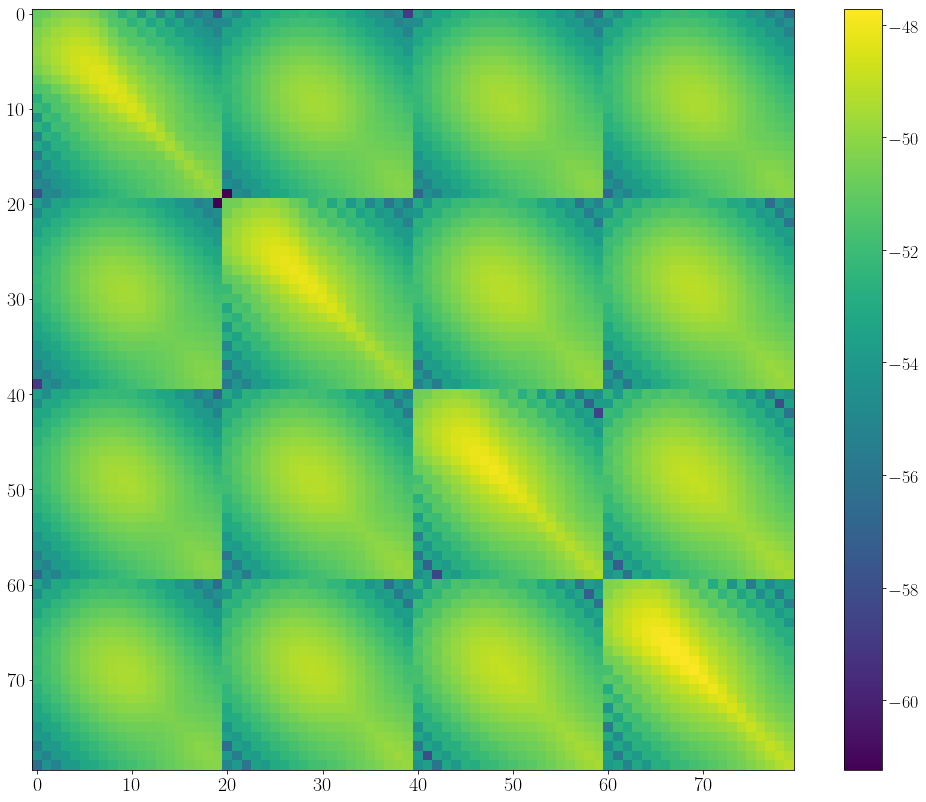

In [21]:
pl.figure( figsize = (18,14))
# pl.imshow(np.log(np.abs(twoptf['cov_total'])))
pl.imshow(np.log(np.abs(cov1)))
# pl.imshow(np.log(np.abs(df['COVMAT'].data)))
pl.colorbar()
pl.tick_params(axis='both', which='minor', labelsize=20)    
pl.tick_params(axis='both', which='major', labelsize=20)






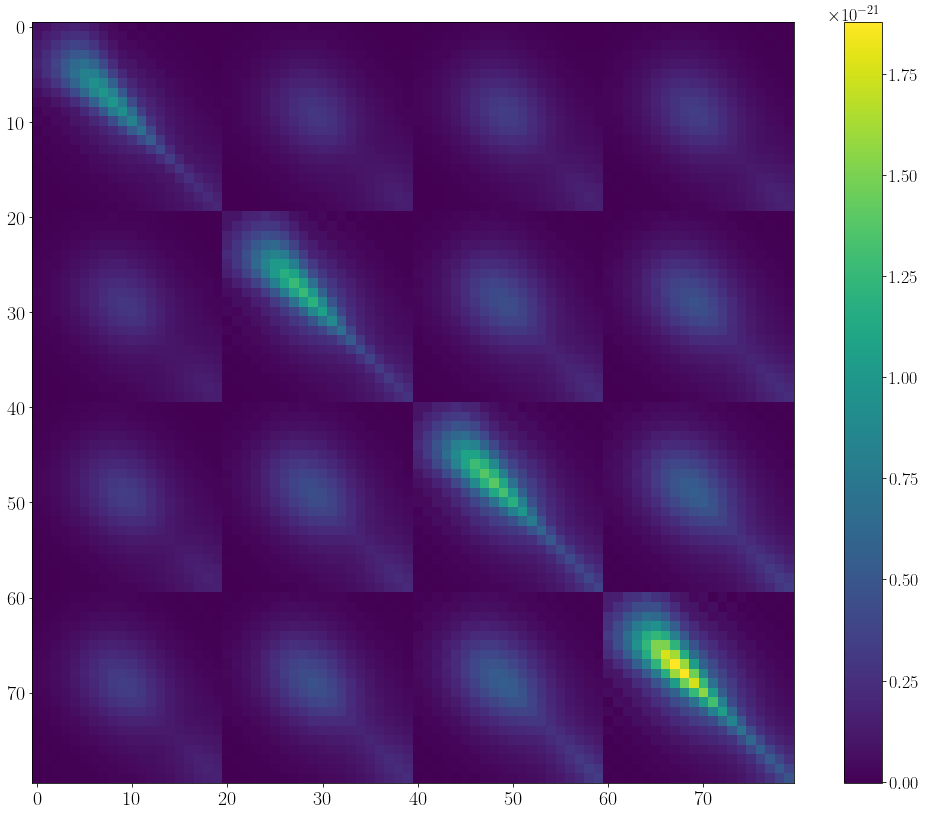

In [23]:
pl.figure( figsize = (18,14))
# pl.imshow(np.log(np.abs(twoptf['cov_total'])))
# pl.imshow(np.log(np.abs(cov2)))
pl.imshow(((cov2)))
pl.colorbar()
pl.tick_params(axis='both', which='minor', labelsize=20)    
pl.tick_params(axis='both', which='major', labelsize=20)







In [27]:
np.savetxt('cov_ky_ky.txt',cov2)




In [33]:
# np.linalg.cholesky(get_corr(cov2))
v, c = np.linalg.eig(get_corr(cov2))
print(np.sort(v))




[-5.76619655e-06 -2.57300209e-06 -1.66915415e-06 -1.47194047e-06
  3.42401526e-07  6.75523372e-07  1.64715695e-06  7.14394488e-06
  8.24254904e-04  8.85580769e-04  9.30680387e-04  9.77750529e-04
  1.82000302e-03  2.01054947e-03  2.37617743e-03  5.90548909e-03
  1.53898133e-02  1.67038410e-02  1.81521906e-02  2.11502398e-02
  5.13134627e-02  5.53709646e-02  5.85887749e-02  6.24841244e-02
  8.54998421e-02  1.03884623e-01  1.16734180e-01  1.29147857e-01
  1.38053690e-01  1.50600836e-01  1.66766334e-01  1.68170644e-01
  1.92029731e-01  2.00500921e-01  2.04159034e-01  2.22543001e-01
  2.23134882e-01  2.24667522e-01  2.41718612e-01  2.55174975e-01
  2.68519460e-01  2.79884946e-01  2.96770029e-01  3.25770952e-01
  3.43061065e-01  3.51933839e-01  3.73972084e-01  4.10986942e-01
  4.41933070e-01  4.50153195e-01  4.74809068e-01  5.25898874e-01
  5.58990428e-01  5.71351672e-01  5.99189553e-01  6.66197311e-01
  6.68236567e-01  7.14387336e-01  7.56118731e-01  8.21466332e-01
  8.47784817e-01  9.49464

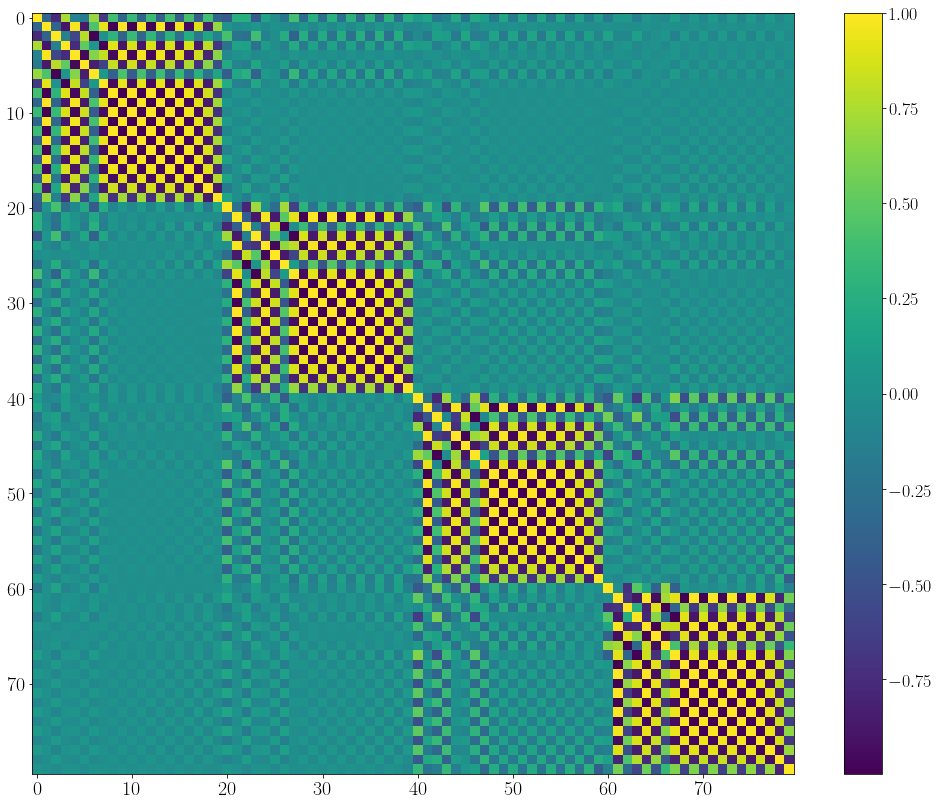

In [12]:


pl.figure( figsize = (18,14))
# pl.imshow(np.log(np.abs(twoptf['cov_total'])))
pl.imshow(get_corr((invcov1)))
# pl.imshow(np.log(np.abs(df['COVMAT'].data)))
pl.colorbar()
pl.tick_params(axis='both', which='minor', labelsize=20)    
pl.tick_params(axis='both', which='major', labelsize=20)




In [40]:
np.diag(invcov2)


array([ 1.68052410e+27, -2.95442299e+26,  1.89163589e+27,  7.58226273e+26,
       -4.86206153e+26, -5.48016975e+25,  2.15699701e+25,  3.63870484e+24,
       -1.31720545e+24, -1.18236607e+24, -6.31539349e+23, -2.99627879e+23,
       -1.31670119e+23, -4.88058108e+22, -7.33771385e+21,  1.35027296e+22,
        2.53530711e+22,  3.04855544e+22,  3.37640295e+22,  2.21723667e+22,
        1.41172496e+27, -1.26683402e+26,  2.11972043e+27,  5.21268947e+26,
       -1.09856706e+26,  7.65556491e+25,  2.52088839e+25,  2.51098143e+24,
       -4.13113673e+23, -3.92434694e+23, -1.95487725e+23, -7.86521132e+22,
       -2.08510597e+22,  6.54819511e+21,  1.94001948e+22,  2.51496383e+22,
        2.84888048e+22,  2.92202807e+22,  2.95179676e+22,  1.91942331e+22,
        9.32022775e+26, -7.04130741e+25,  1.40575094e+27,  3.55364895e+26,
       -5.59155958e+25,  5.45526361e+25,  1.69165046e+25,  1.83654262e+24,
       -9.77923193e+22, -1.44736143e+23, -6.00239967e+22, -9.15752494e+21,
        1.43145729e+22,  

In [39]:
get_corr((invcov2))[0,:]


/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


array([ 1.        ,         nan, -1.06460714,  1.11635479,         nan,
               nan,  1.07574381, -1.17914828,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       -1.82592971,  1.10557817, -0.8082051 ,  0.61159796, -0.41220094,
       -0.67498097,         nan,  0.84905233, -0.41973357,         nan,
        1.4451177 , -0.86271143,  0.29555294,         nan,         nan,
               nan,         nan,         nan, -1.48696049,  0.6024109 ,
       -0.36815273,  0.23952177, -0.15528007,  0.09785309, -0.03631553,
        0.21839359,         nan, -0.27944056,  0.12197713,         nan,
       -0.47122275,  0.28161963, -0.07083805,         nan,         nan,
               nan,         nan, -0.48772738,  0.27103589, -0.18493863,
        0.13486599, -0.09975211,  0.07508383, -0.05933745,  0.05253709,
       -0.10517611,         nan,  0.13208024, -0.06496035,         nan,
        0.21485894, -0.13413008,  0.04675115,         nan,      

/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


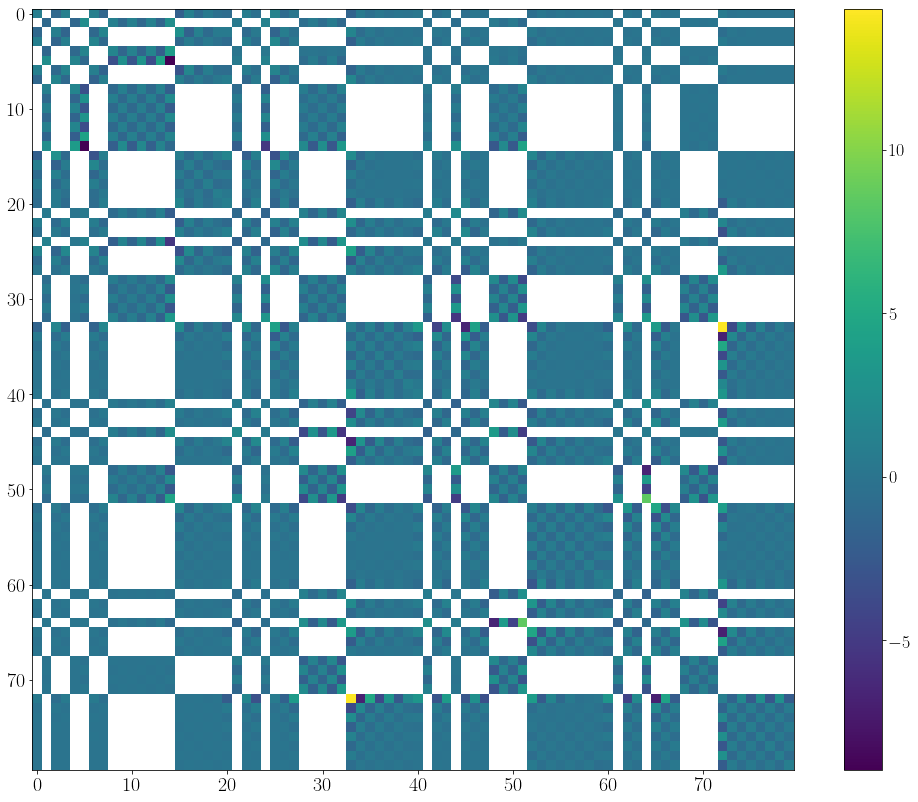

In [34]:
pl.figure( figsize = (18,14))
# pl.imshow(np.log(np.abs(twoptf['cov_total'])))
# pl.imshow(np.log(np.abs(invcov2)))
pl.imshow(get_corr((invcov2)))
# pl.imshow(np.log(np.abs(df['COVMAT'].data)))
pl.colorbar()
pl.tick_params(axis='both', which='minor', labelsize=20)    
pl.tick_params(axis='both', which='major', labelsize=20)



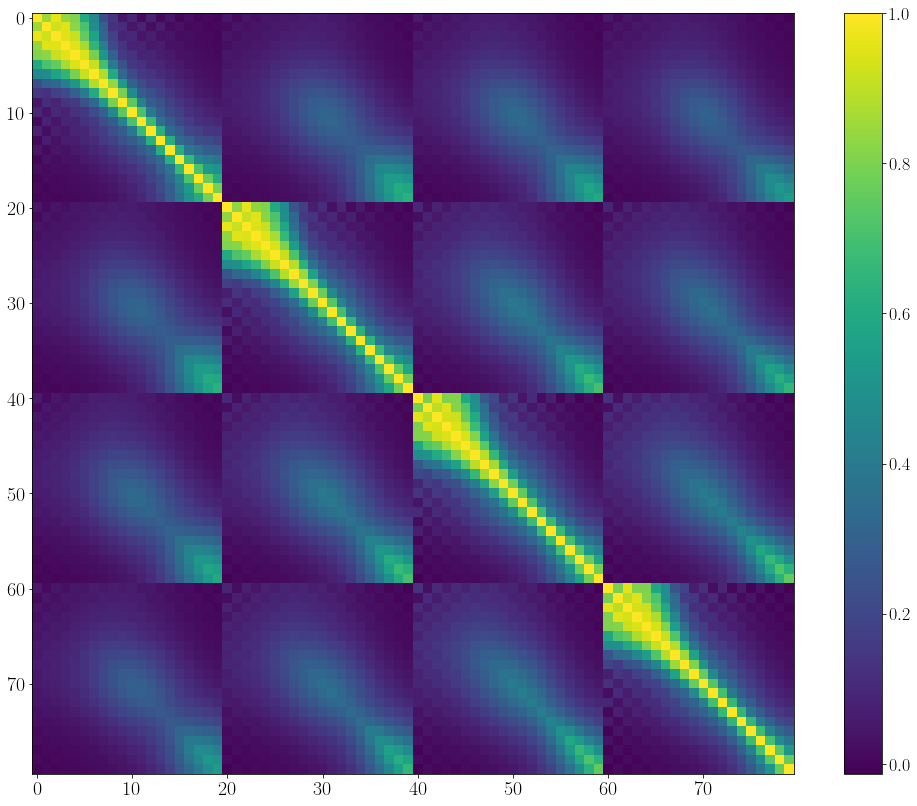

In [35]:
pl.figure( figsize = (18,14))
# pl.imshow(np.log(np.abs(twoptf['cov_total'])))
# pl.imshow(np.log(np.abs(invcov2)))
pl.imshow(get_corr((cov2)))
# pl.imshow(np.log(np.abs(df['COVMAT'].data)))
pl.colorbar()
pl.tick_params(axis='both', which='minor', labelsize=20)    
pl.tick_params(axis='both', which='major', labelsize=20)





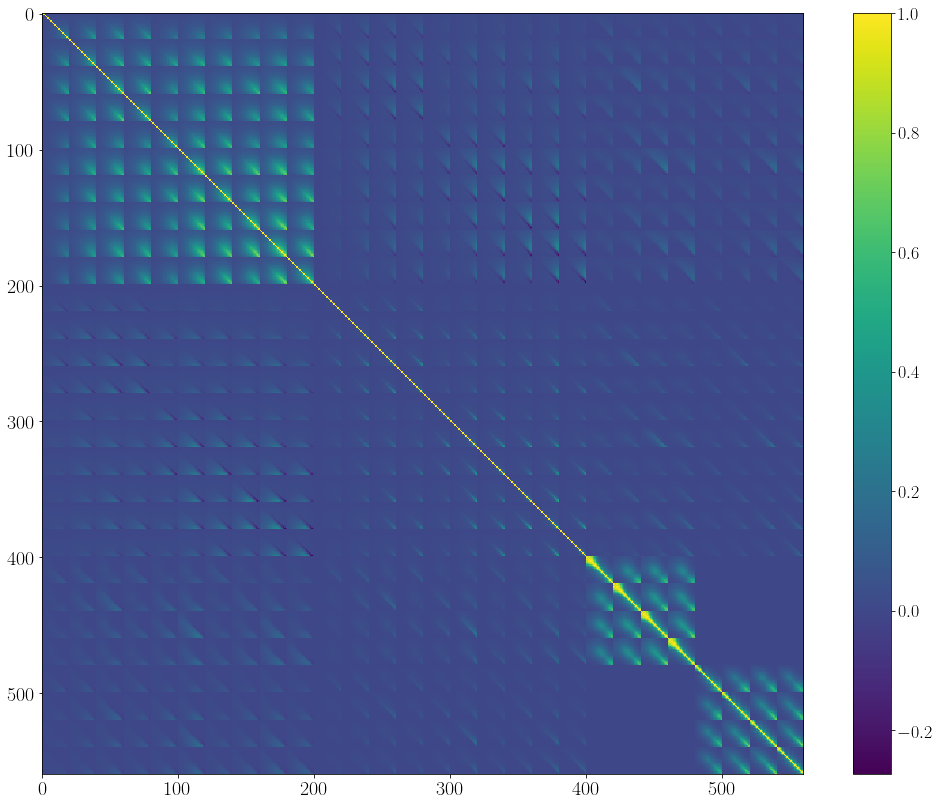

In [3]:
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as pl
font = {'size'   : 18}
matplotlib.rc('font', **font)
# # Latex stuff
pl.rc('text', usetex=True)
pl.rc('font', family='serif')



df = fits.open(sdir + 'DES_planckACT_theorycov_actmask.fits')
def get_corr(cov):
    corr = np.zeros(cov.shape)
    for ii in range(0, cov.shape[0]):
        for jj in range(0, cov.shape[1]):
            corr[ii, jj] = cov[ii, jj] / np.sqrt(cov[ii, ii] * cov[jj, jj])
    return corr

pl.figure( figsize = (18,14))
# pl.imshow(np.log(np.abs(twoptf['cov_total'])))
pl.imshow(get_corr((df['COVMAT'].data)))
# pl.imshow(np.log(np.abs(df['COVMAT'].data)))
pl.colorbar()
pl.tick_params(axis='both', which='minor', labelsize=20)    
pl.tick_params(axis='both', which='major', labelsize=20)


# pl.title(r'$\mathcal{C}(\xi_{+},\xi_{-},\langle \gamma_t y \rangle)$')
# pl.savefig('cov_total.pdf')









In [4]:
def is_symm(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)




In [8]:
is_symm(((df['COVMAT'].data)),rtol=1e-90,atol=1e-90)




True

In [20]:
v,c = np.linalg.eig(df['COVMAT'].data)
cov_t = (np.dot(c,np.dot(np.diag(v),np.linalg.inv(c))))




[[4.01922016e-11 3.12996100e-13 2.70473640e-13 ... 1.05575523e-18
  8.84812678e-19 7.38699701e-19]
 [3.12996100e-13 2.54256215e-11 2.52972840e-13 ... 1.03777492e-18
  8.85739851e-19 7.28039963e-19]
 [2.70473640e-13 2.52972840e-13 1.60932049e-11 ... 1.02927107e-18
  8.69939752e-19 7.29308307e-19]
 ...
 [1.05575523e-18 1.03777492e-18 1.02927107e-18 ... 4.59447107e-21
  3.01774222e-21 1.58780841e-21]
 [8.84812678e-19 8.85739851e-19 8.69939752e-19 ... 3.01774222e-21
  3.99318345e-21 2.46065813e-21]
 [7.38699701e-19 7.28039963e-19 7.29308307e-19 ... 1.58780841e-21
  2.46065813e-21 3.49340708e-21]]


In [29]:

v1 = np.copy(v)
ind_neg = np.where(v1 < 0)[0]
v1[ind_neg] = np.amin(np.abs(v1)) * np.ones(len(ind_neg))
cov_t1 = (np.dot(c,np.dot(np.diag(v1),np.linalg.inv(c))))



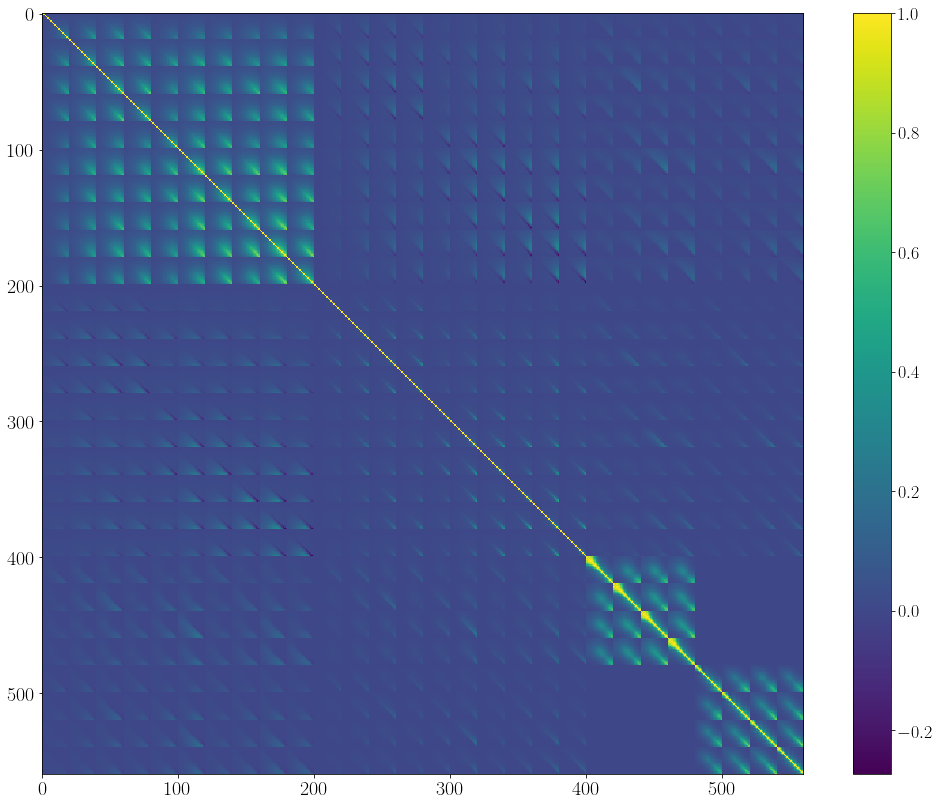

In [28]:
pl.figure( figsize = (18,14))
# pl.imshow(np.log(np.abs(twoptf['cov_total'])))
pl.imshow(get_corr(cov_t))
# pl.imshow(np.log(np.abs(df['COVMAT'].data)))
pl.colorbar()
pl.tick_params(axis='both', which='minor', labelsize=20)    
pl.tick_params(axis='both', which='major', labelsize=20)




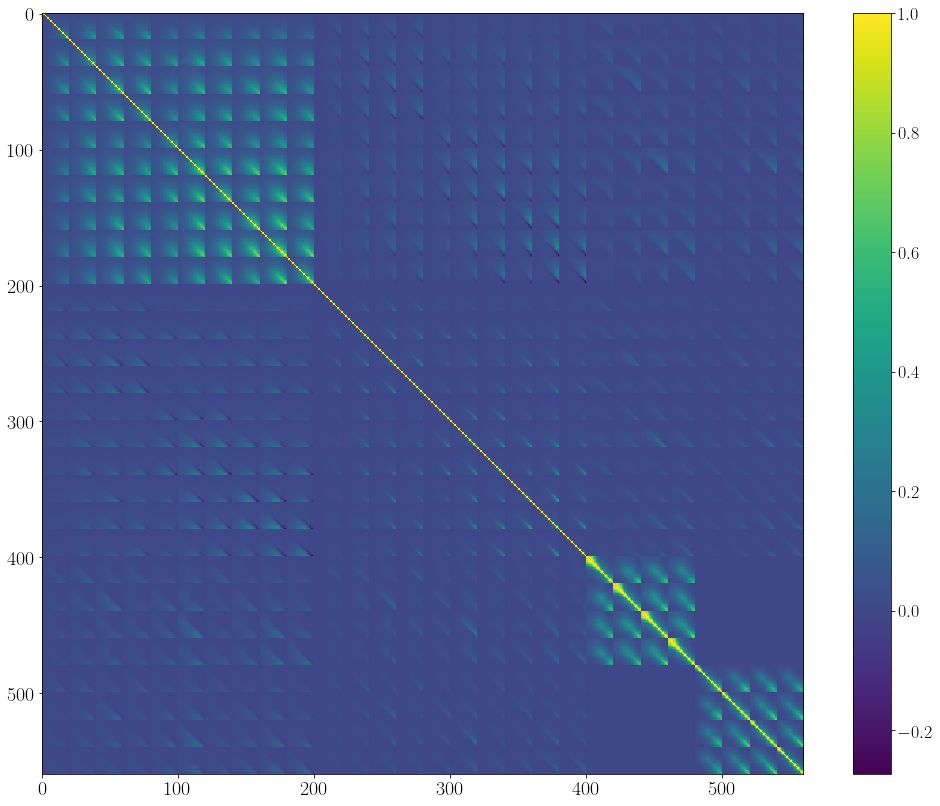

In [30]:
pl.figure( figsize = (18,14))
# pl.imshow(np.log(np.abs(twoptf['cov_total'])))
pl.imshow(get_corr(cov_t1))
# pl.imshow(np.log(np.abs(df['COVMAT'].data)))
pl.colorbar()
pl.tick_params(axis='both', which='minor', labelsize=20)    
pl.tick_params(axis='both', which='major', labelsize=20)





In [32]:
# np.linalg.det(df['COVMAT'].data[:400,:400])

np.linalg.cholesky(cov_t1)



array([[6.33973198e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.93705571e-08, 5.04214082e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.26632610e-08, 4.97539716e-08, 4.01109826e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.66529948e-13, 2.04189703e-13, 2.52301751e-13, ...,
        3.83879739e-11, 0.00000000e+00, 0.00000000e+00],
       [1.39566259e-13, 1.74300841e-13, 2.13236671e-13, ...,
        2.05286456e-11, 3.29158460e-11, 0.00000000e+00],
       [1.16519074e-13, 1.43250135e-13, 1.78806380e-13, ...,
        3.19570904e-12, 1.64113016e-11, 3.12424209e-11]])

In [27]:
dd_ACT.xi_result_dict['gty']['theta']


array([  2.51658551,   3.16816649,   3.98845137,   5.02112006,
         6.32116185,   7.95780356,  10.01819588,  12.61205406,
        15.87750024,  19.98841844,  25.16371379,  31.67896917,
        39.88111995,  50.20692813,  63.20623983,  79.5712644 ,
       100.17343439, 126.10980903, 158.76149232, 199.86717635,
       251.61572621])

In [28]:
dd.xi_result_dict['gty']['theta']



array([  2.51658674,   3.168195  ,   3.9885212 ,   5.0212507 ,
         6.32138011,   7.95814606,  10.01871231,  12.61281153,
        15.87858896,  19.98995916,  25.16586758,  31.68195023,
        39.88521227,  50.21250732,  63.2138015 ,  79.58146113,
       100.1871238 , 126.12811617, 158.78589071, 199.89959298])

In [29]:
theta1 = np.array([0.00083136, 0.00103403, 0.00130175, 0.0016388 , 0.0020631  ,0.00259727,
 0.00326974, 0.00411633, 0.00518211, 0.00652383, 0.00821295, 0.0103394,
 0.01301642, 0.01638656, 0.02062929, 0.02597051, 0.03269466, 0.04115979,
 0.05181666, 0.06483276])
theta1*(60./((2*math.pi)/360))




array([  2.85800516,   3.55473329,   4.47508686,   5.63377941,
         7.09241536,   8.92875656,  11.24053813,  14.15090016,
        17.81478192,  22.42727552,  28.23404234,  35.54423896,
        44.74715582,  56.33284372,  70.91827508,  89.28003689,
       112.39596184, 141.49693516, 178.13255559, 222.87861133])

In [66]:
theta_temp = np.logspace(np.log10(2.5),np.log10(250.), 21)
theta_temp_rad = theta_temp*(1./60.)*(np.pi/180.)
ell_temp = (1./theta_temp_rad)[::-1]





In [67]:
logell_temp = np.log(ell_temp)
dell = logell_temp[1] - logell_temp[0]
log_lmax = np.log(50000)
log_lmin = np.log(1)
logell_rightext = np.arange(logell_temp[-1],log_lmax,dell)
logell_leftext = np.arange(logell_temp[0],log_lmin,-dell)[::-1]
logell_cen = np.hstack((logell_leftext[:-1],logell_temp,logell_rightext))
logell_all = (logell_cen[1:] + logell_cen[:-1])/2.
logell_all = np.insert(logell_all,[0,len(logell_all)],[logell_all[0]-dell,logell_all[-1]+dell])
ell_cen = np.exp(logell_cen)
dell_all = np.exp(logell_all)[1:] - np.exp(logell_all[:-1])




In [63]:
np.exp(logell_all)


array([9.73495334e-01, 1.22555801e+00, 1.54288613e+00, 1.94237855e+00,
       2.44530972e+00, 3.07846255e+00, 3.87555473e+00, 4.87903433e+00,
       6.14234031e+00, 7.73274830e+00, 9.73495334e+00, 1.22555801e+01,
       1.54288613e+01, 1.94237855e+01, 2.44530972e+01, 3.07846255e+01,
       3.87555473e+01, 4.87903433e+01, 6.14234031e+01, 7.73274830e+01,
       9.73495334e+01, 1.22555801e+02, 1.54288613e+02, 1.94237855e+02,
       2.44530972e+02, 3.07846255e+02, 3.87555473e+02, 4.87903433e+02,
       6.14234031e+02, 7.73274830e+02, 9.73495334e+02, 1.22555801e+03,
       1.37509871e+03, 1.54288613e+03, 1.94237855e+03, 2.44530972e+03,
       3.07846255e+03, 3.87555473e+03, 4.87903433e+03, 6.14234031e+03,
       7.73274830e+03, 9.73495334e+03, 1.22555801e+04, 1.54288613e+04,
       1.94237855e+04, 2.44530972e+04, 3.07846255e+04, 3.87555473e+04,
       4.87903433e+04])

In [64]:
np.exp(logell_cen)


array([1.09227973e+00, 1.37509871e+00, 1.73114671e+00, 2.17938458e+00,
       2.74368263e+00, 3.45409179e+00, 4.34844393e+00, 5.47436656e+00,
       6.89181918e+00, 8.67628629e+00, 1.09227973e+01, 1.37509871e+01,
       1.73114671e+01, 2.17938458e+01, 2.74368263e+01, 3.45409179e+01,
       4.34844393e+01, 5.47436656e+01, 6.89181918e+01, 8.67628629e+01,
       1.09227973e+02, 1.37509871e+02, 1.73114671e+02, 2.17938458e+02,
       2.74368263e+02, 3.45409179e+02, 4.34844393e+02, 5.47436656e+02,
       6.89181918e+02, 8.67628629e+02, 1.09227973e+03, 1.37509871e+03,
       1.37509871e+03, 1.73114671e+03, 2.17938458e+03, 2.74368263e+03,
       3.45409179e+03, 4.34844393e+03, 5.47436656e+03, 6.89181918e+03,
       8.67628629e+03, 1.09227973e+04, 1.37509871e+04, 1.73114671e+04,
       2.17938458e+04, 2.74368263e+04, 3.45409179e+04, 4.34844393e+04])

In [65]:
dell_all


array([2.52062680e-01, 3.17328113e-01, 3.99492426e-01, 5.02931167e-01,
       6.33152826e-01, 7.97092182e-01, 1.00347960e+00, 1.26330597e+00,
       1.59040799e+00, 2.00220504e+00, 2.52062680e+00, 3.17328113e+00,
       3.99492426e+00, 5.02931167e+00, 6.33152826e+00, 7.97092182e+00,
       1.00347960e+01, 1.26330597e+01, 1.59040799e+01, 2.00220504e+01,
       2.52062680e+01, 3.17328113e+01, 3.99492426e+01, 5.02931167e+01,
       6.33152826e+01, 7.97092182e+01, 1.00347960e+02, 1.26330597e+02,
       1.59040799e+02, 2.00220504e+02, 2.52062680e+02, 1.49540695e+02,
       1.67787419e+02, 3.99492426e+02, 5.02931167e+02, 6.33152826e+02,
       7.97092182e+02, 1.00347960e+03, 1.26330597e+03, 1.59040799e+03,
       2.00220504e+03, 2.52062680e+03, 3.17328113e+03, 3.99492426e+03,
       5.02931167e+03, 6.33152826e+03, 7.97092182e+03, 1.00347960e+04])